In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys

In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
import plotly.express as px
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

from sklearn import linear_model as lm
from sklearn.feature_selection import r_regression
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [4]:
approval = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS-FKWVTTFtJT6u56e0bqdfoMcXvDO1DUChsJ3jQAMB2lZk2SMqVfmg7dGjclTYkYWz-Pm5lfcLPjp4/pub?output=csv')
# approval = approval.reset_index()
# approval = approval.rename({'index':'poll_id'}, axis=1)
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,tracking,approve,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp
0,Donald Trump (2nd term),Trade,AtlasIntel,NaN,12/15/2025,12/19/2025,2315.0,A,2.050922,1.583896,NaN,35.0,61.0,-26.0,34.42171,61.09238,-26.670670,https://www.atlasintel.org/poll/usa-national-2...,12/19/2025,16:01:07 28 Dec 2025
1,Donald Trump (2nd term),Economy,AtlasIntel,NaN,12/15/2025,12/19/2025,2315.0,A,2.050922,1.583896,NaN,35.0,60.0,-25.0,34.62851,59.97962,-25.351110,https://www.atlasintel.org/poll/usa-national-2...,12/19/2025,16:01:01 28 Dec 2025
2,Donald Trump (2nd term),All polls,AtlasIntel,NaN,12/15/2025,12/19/2025,2315.0,A,2.050922,1.583896,NaN,39.3,59.6,-20.3,39.06337,58.23878,-19.175410,https://www.atlasintel.org/poll/usa-national-2...,12/19/2025,16:00:34 28 Dec 2025
3,Donald Trump (2nd term),Immigration,AtlasIntel,NaN,12/15/2025,12/19/2025,2315.0,A,2.050922,1.583896,NaN,41.0,57.0,-16.0,41.34027,55.33730,-13.997030,https://www.atlasintel.org/poll/usa-national-2...,12/19/2025,16:01:04 28 Dec 2025
4,Donald Trump (2nd term),Adults,AtlasIntel,NaN,12/15/2025,12/19/2025,2315.0,A,2.050922,1.583896,NaN,39.3,59.6,-20.3,38.22596,58.94910,-20.723140,https://www.atlasintel.org/poll/usa-national-2...,12/19/2025,16:00:49 28 Dec 2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,Donald Trump (2nd term),Immigration,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,NaN,46.0,39.0,7.0,47.87732,39.53010,8.347218,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,16:01:04 28 Dec 2025
3514,Donald Trump (2nd term),Strong,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,NaN,29.0,29.0,0.0,33.31039,29.07017,4.240221,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,16:00:53 28 Dec 2025
3515,Donald Trump (2nd term),Cost,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.996709,0.000000,NaN,35.0,41.0,-6.0,38.42154,41.18378,-2.762241,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,16:01:05 28 Dec 2025
3516,Donald Trump (2nd term),Voters,InsiderAdvantage,NaN,1/20/2025,1/20/2025,800.0,RV,1.093180,0.000000,NaN,56.0,39.0,17.0,52.86094,42.46825,10.392690,https://insideradvantage.com/first-insideradva...,1/20/2025,16:00:44 28 Dec 2025


In [5]:
# approval[approval['pollster']=='YouGov'][approval['subgroup']=='All polls']

In [6]:
approval = approval[~approval['subgroup'].isin(['Weak', 'Strong', 'Economy', 'Cost', 'Immigration', 'Trade', 'Adults', 'Voters'])]

In [7]:
# approval.compare(pd.read_csv('trump_approval_polls.csv'))

In [8]:
# TODO: Rework this a little
compare_df = pd.merge(approval, pd.read_csv('trump_approval_polls.csv'), how='outer', indicator=True)
new_polls = compare_df[compare_df['_merge'] == 'left_only']
new_polls.shape

(762, 22)

In [9]:
del new_polls

In [10]:
approval.to_csv('trump_approval_polls.csv')

In [11]:
approval.columns.values

array(['president', 'subgroup', 'pollster', 'sponsors', 'startdate',
       'enddate', 'samplesize', 'population', 'weight', 'influence',
       'tracking', 'approve', 'disapprove', 'net', 'adjusted_approve',
       'adjusted_disapprove', 'adjusted_net', 'url', 'createddate',
       'timestamp'], dtype=object)

In [12]:
approval.shape

(762, 20)

In [13]:
# dates = approval['Dates'].str.extract(r'(\d{1,2}\/\d{1,2}) \- (\d{1,2}\/\d{1,2}), (\d{4})')
# dates

In [14]:
# dates['end_date'] = dates[1] + '/' + dates[2]
# dates['end_date'] = pd.to_datetime(dates['end_date'])
# dates

In [15]:
# approval['Dates'] = dates['end_date']
# approval.head()

In [16]:
# samples = approval['Sample'].str.extract(r'[0-9,]{3,5} (\w{1,2})@@(\d{3,4})')
# samples

In [17]:
# approval['population'] = samples[0]
# approval['sample_size'] = samples[1].astype(int)
# approval.head()

In [18]:
ratings = pd.read_csv('pollster_ratings_silver.csv')
ratings

,Pollster,Grade,Predictive Plus-Minus,Mean-reverted bias,Number of polls,cat
0,AtlasIntel,A+@@1,-0.957740,D+0.16@@0.16334188,91,D+
1,Marquette University Law School,A/B@@4,-0.920261,D+0.32@@0.31545374,17,D+
2,The Washington Post,A+@@1,-0.902281,D+0.90@@0.89811021,98,D+
3,Research & Polling Inc.,A@@2,-0.871136,R+0.55@@-0.54944503,44,R+
4,The New York Times/Siena College,A@@2,-0.763947,D+1.41@@1.4121077,116,D+
...,...,...,...,...,...,...
530,Nielson Brothers Polling,C/D@@12,1.946864,D+3.05@@3.0515239,11,D+
531,Ascend Action,C/D@@12,2.282717,D+3.35@@3.3485439,6,D+
532,Jayhawk Consulting Services,C/D@@12,2.353968,D+2.27@@2.2674108,2,D+
533,Fort Hays State University,C/D@@12,2.489170,R+1.10@@-1.0960908,6,R+


In [19]:
ratings['Pollster'].values

array(['AtlasIntel', 'Marquette University Law School',
       'The Washington Post', 'Research & Polling Inc.',
       'The New York Times/Siena College', 'Cygnal', 'SurveyUSA',
       'Siena College', 'Beacon Research/Shaw & Co. Research',
       'Alaska Survey Research', 'OnMessage Inc.', 'TIPP Insights',
       'Emerson College', 'Landmark Communications',
       'Monmouth University', 'Data Orbital',
       'University of North Florida', 'MassINC Polling Group',
       'Marist College', 'Public Policy Institute of California',
       'Public Policy Polling', 'University of California Berkeley',
       'CBS News/The New York Times', 'Christopher Newport University',
       'Mason-Dixon Polling & Strategy', 'Strategic Vision LLC',
       'Suffolk University', 'Stockton University',
       'Field Research Corp. (Field Poll)', 'Quinnipiac University',
       'Los Angeles Times',
       'Hart Research Associates/Public Opinion Strategies',
       'Public Opinion Strategies', 'Susquehan

In [20]:
ratings[ratings['Pollster'].str.contains('North Star')]#.sum()

,Pollster,Grade,Predictive Plus-Minus,Mean-reverted bias,Number of polls,cat
75,North Star Opinion Research,B/C@@8,0.043339,R+0.63@@-0.62697512,13,R+
425,Univision/Latino Decisions/North Star Opinion ...,B/C@@8,0.830409,D+1.06@@1.0564657,7,D+


In [21]:
banned_pollsters = ratings[ratings['Grade'].str.contains('F')]['Pollster'].values
banned_pollsters

array(['Strategic Vision LLC', 'Pharos Research Group', 'Research 2000',
       'Big Data Poll', 'Overtime Politics', 'Rethink Priorities',
       'Blumenthal Research Daily', 'CSP Polling', 'KG Polling',
       'OurProgress (The Progress Campaign)', 'TCJ Research'],
      dtype=object)

In [22]:
approval = approval[~approval['pollster'].isin(banned_pollsters)]
approval.shape

(762, 20)

In [23]:
approval = pd.merge(left=approval, right=ratings[['Pollster', 'Predictive Plus-Minus']], left_on='pollster',
                   right_on='Pollster', how='left')
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus
0,Donald Trump (2nd term),All polls,AtlasIntel,NaN,12/15/2025,12/19/2025,2315.0,A,2.050922,1.583896,...,59.6,-20.300000,39.06337,58.23878,-19.175410,https://www.atlasintel.org/poll/usa-national-2...,12/19/2025,16:00:34 28 Dec 2025,AtlasIntel,-0.957740
1,Donald Trump (2nd term),All polls,InsiderAdvantage,NaN,12/19/2025,12/20/2025,800.0,LV,1.086069,1.024065,...,41.1,8.400002,45.80431,44.88195,0.922359,https://insideradvantage.com/national-trump-ap...,12/20/2025,16:00:34 28 Dec 2025,InsiderAdvantage,0.034562
2,Donald Trump (2nd term),All polls,Emerson College,NaN,12/14/2025,12/15/2025,1000.0,RV,1.375719,0.903320,...,50.3,-9.500000,40.41942,52.99877,-12.579350,https://emersoncollegepolling.com/december-202...,12/15/2025,16:00:34 28 Dec 2025,Emerson College,-0.569153
3,Donald Trump (2nd term),All polls,Beacon Research/Shaw & Co. Research,FOX News,12/12/2025,12/15/2025,1001.0,RV,1.409894,0.846650,...,56.0,-12.000000,43.33638,55.19897,-11.862590,https://www.foxnews.com/politics/fox-news-poll...,12/15/2025,16:00:34 28 Dec 2025,Beacon Research/Shaw & Co. Research,-0.635562
4,Donald Trump (2nd term),All polls,American Research Group,NaN,12/17/2025,12/20/2025,1100.0,A,0.905691,0.802337,...,62.0,-27.000000,37.90522,59.29020,-21.384980,https://americanresearchgroup.com/economy/,12/20/2025,16:00:34 28 Dec 2025,American Research Group,0.818141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,Donald Trump (2nd term),All polls,Research Co.,NaN,1/22/2025,1/24/2025,1001.0,A,0.951747,0.000000,...,46.0,4.000000,50.01678,45.42477,4.592010,https://researchco.ca/2025/01/27/immigration-usa/,1/24/2025,16:00:34 28 Dec 2025,Research Co.,0.632258
758,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,1/20/2025,1/23/2025,3000.0,RV,0.927446,0.000000,...,39.0,18.000000,52.73811,41.95698,10.781130,https://x.com/ScottWRasmussen/status/188280455...,1/23/2025,16:00:34 28 Dec 2025,RMG Research,0.278023
759,Donald Trump (2nd term),All polls,AtlasIntel,NaN,1/21/2025,1/23/2025,1882.0,A,1.910964,0.000000,...,49.7,0.399998,49.86337,48.33878,1.524590,https://cdn.atlasintel.org/ed3f5238-e823-495e-...,1/23/2025,16:00:34 28 Dec 2025,AtlasIntel,-0.957740
760,Donald Trump (2nd term),All polls,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,...,41.0,6.000000,48.96083,39.28248,9.678352,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,16:00:34 28 Dec 2025,Ipsos,0.442898


In [24]:
approval.shape

(762, 22)

In [25]:
approval['Pollster'].value_counts()

Pollster
Rasmussen Reports                                     235
YouGov                                                 84
Morning Consult                                        60
RMG Research                                           46
Ipsos                                                  32
Global Strategy Group/GBAO (Navigator Research)        18
J.L. Partners                                          17
TIPP Insights                                          15
Echelon Insights                                       14
Emerson College                                        12
Harris Insights & Analytics                            12
Gallup                                                 12
American Research Group                                11
Quinnipiac University                                  11
John Zogby Strategies                                   9
AtlasIntel                                              8
Clarity Campaign Labs                                   8
Insid

In [26]:
# approval[~approval['tracking'].isna()]

In [27]:
approval['tracking'].value_counts()

tracking
True    243
Name: count, dtype: int64

In [28]:
# full_approval = approval.copy()

In [29]:
approval = approval[(~approval['samplesize'].isna())]
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus
0,Donald Trump (2nd term),All polls,AtlasIntel,NaN,12/15/2025,12/19/2025,2315.0,A,2.050922,1.583896,...,59.6,-20.300000,39.06337,58.23878,-19.175410,https://www.atlasintel.org/poll/usa-national-2...,12/19/2025,16:00:34 28 Dec 2025,AtlasIntel,-0.957740
1,Donald Trump (2nd term),All polls,InsiderAdvantage,NaN,12/19/2025,12/20/2025,800.0,LV,1.086069,1.024065,...,41.1,8.400002,45.80431,44.88195,0.922359,https://insideradvantage.com/national-trump-ap...,12/20/2025,16:00:34 28 Dec 2025,InsiderAdvantage,0.034562
2,Donald Trump (2nd term),All polls,Emerson College,NaN,12/14/2025,12/15/2025,1000.0,RV,1.375719,0.903320,...,50.3,-9.500000,40.41942,52.99877,-12.579350,https://emersoncollegepolling.com/december-202...,12/15/2025,16:00:34 28 Dec 2025,Emerson College,-0.569153
3,Donald Trump (2nd term),All polls,Beacon Research/Shaw & Co. Research,FOX News,12/12/2025,12/15/2025,1001.0,RV,1.409894,0.846650,...,56.0,-12.000000,43.33638,55.19897,-11.862590,https://www.foxnews.com/politics/fox-news-poll...,12/15/2025,16:00:34 28 Dec 2025,Beacon Research/Shaw & Co. Research,-0.635562
4,Donald Trump (2nd term),All polls,American Research Group,NaN,12/17/2025,12/20/2025,1100.0,A,0.905691,0.802337,...,62.0,-27.000000,37.90522,59.29020,-21.384980,https://americanresearchgroup.com/economy/,12/20/2025,16:00:34 28 Dec 2025,American Research Group,0.818141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,Donald Trump (2nd term),All polls,Research Co.,NaN,1/22/2025,1/24/2025,1001.0,A,0.951747,0.000000,...,46.0,4.000000,50.01678,45.42477,4.592010,https://researchco.ca/2025/01/27/immigration-usa/,1/24/2025,16:00:34 28 Dec 2025,Research Co.,0.632258
758,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,1/20/2025,1/23/2025,3000.0,RV,0.927446,0.000000,...,39.0,18.000000,52.73811,41.95698,10.781130,https://x.com/ScottWRasmussen/status/188280455...,1/23/2025,16:00:34 28 Dec 2025,RMG Research,0.278023
759,Donald Trump (2nd term),All polls,AtlasIntel,NaN,1/21/2025,1/23/2025,1882.0,A,1.910964,0.000000,...,49.7,0.399998,49.86337,48.33878,1.524590,https://cdn.atlasintel.org/ed3f5238-e823-495e-...,1/23/2025,16:00:34 28 Dec 2025,AtlasIntel,-0.957740
760,Donald Trump (2nd term),All polls,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,...,41.0,6.000000,48.96083,39.28248,9.678352,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,16:00:34 28 Dec 2025,Ipsos,0.442898


In [30]:
auxiliary = pd.read_csv('auxiliary_pollster_rating_stats.csv')
auxiliary

,Pollster,Correct calls,Outside MoE,House effect,ADPA,Herding penalty,herd_cat,p_cat
0,AtlasIntel,0.840659,8.8%@@91.208791,R+2.00@@-1.9990723,3.7@@3.6687982,0.096047,2,R+
1,The Washington Post,0.693878,6.1%@@93.877551,D+1.02@@1.0173736,3.6@@3.5756676,0.221841,3,D+
2,Research & Polling Inc.,0.886364,9.1%@@90.9090906,D+0.63@@0.63289553,4.6@@4.642076,0.286276,3,D+
3,The New York Times/Siena College,0.737069,18.1%@@81.896552,D+0.79@@0.79133403,3.2@@3.2483816,0.280332,3,D+
4,Cygnal,0.939655,13.8%@@86.206897,R+0.60@@-0.59704119,3.5@@3.4644768,0.521310,4,R+
...,...,...,...,...,...,...,...,...
93,Digital Research,0.904762,38.1%@@61.904761,R+2.44@@-2.4431372,11.4@@11.413808,0.000000,1,R+
94,Mitchell Research & Communications,0.695122,39%@@60.975611,R+0.45@@-0.44617203,4.4@@4.4410443,0.229193,3,R+
95,Merriman River Group,0.840000,60%@@39.999998,R+3.23@@-3.2347174,10.3@@10.260222,0.000000,1,R+
96,McLaughlin & Associates,0.689655,34.5%@@65.517241,R+4.94@@-4.9392128,6.2@@6.17804,0.000000,1,R+


In [31]:
# house_eff = auxiliary['House effect'].str.extract(r'(\w)\+(\d\.\d\d)@@*.')
house_eff = auxiliary['House effect'].str.extract(r'(\w)\+\d.\d\d.*@@([\d\.\+\-]+)')
house_eff[1] = house_eff[1].astype(float)
house_eff

,0,1
0,R,-1.999072
1,D,1.017374
2,D,0.632896
3,D,0.791334
4,R,-0.597041
...,...,...
93,R,-2.443137
94,R,-0.446172
95,R,-3.234717
96,R,-4.939213


In [32]:
# R --> -1, D --> 1
house_eff[0] = house_eff[0].replace({'R':-1, 'D':1})
house_eff['house_effect'] = house_eff[1]
house_eff

,0,1,house_effect
0,-1,-1.999072,-1.999072
1,1,1.017374,1.017374
2,1,0.632896,0.632896
3,1,0.791334,0.791334
4,-1,-0.597041,-0.597041
...,...,...,...
93,-1,-2.443137,-2.443137
94,-1,-0.446172,-0.446172
95,-1,-3.234717,-3.234717
96,-1,-4.939213,-4.939213


In [33]:
auxiliary['house_effect'] = house_eff['house_effect']
auxiliary = auxiliary.set_index(['Pollster'])
auxiliary

,Correct calls,Outside MoE,House effect,ADPA,Herding penalty,herd_cat,p_cat,house_effect
Pollster,,,,,,,,
AtlasIntel,0.840659,8.8%@@91.208791,R+2.00@@-1.9990723,3.7@@3.6687982,0.096047,2,R+,-1.999072
The Washington Post,0.693878,6.1%@@93.877551,D+1.02@@1.0173736,3.6@@3.5756676,0.221841,3,D+,1.017374
Research & Polling Inc.,0.886364,9.1%@@90.9090906,D+0.63@@0.63289553,4.6@@4.642076,0.286276,3,D+,0.632896
The New York Times/Siena College,0.737069,18.1%@@81.896552,D+0.79@@0.79133403,3.2@@3.2483816,0.280332,3,D+,0.791334
Cygnal,0.939655,13.8%@@86.206897,R+0.60@@-0.59704119,3.5@@3.4644768,0.521310,4,R+,-0.597041
...,...,...,...,...,...,...,...,...
Digital Research,0.904762,38.1%@@61.904761,R+2.44@@-2.4431372,11.4@@11.413808,0.000000,1,R+,-2.443137
Mitchell Research & Communications,0.695122,39%@@60.975611,R+0.45@@-0.44617203,4.4@@4.4410443,0.229193,3,R+,-0.446172
Merriman River Group,0.840000,60%@@39.999998,R+3.23@@-3.2347174,10.3@@10.260222,0.000000,1,R+,-3.234717


In [34]:
def apply_house_eff(data, pollster):
    df = data[data['pollster']==pollster]
    try:
        df['approve_adj'] = df['approve'] + (auxiliary.loc[pollster, 'house_effect'] / 2)
        df['disapprove_adj'] = df['disapprove'] - (auxiliary.loc[pollster, 'house_effect'] / 2)
    except KeyError:
        df['approve_adj'] = df['approve']
        df['disapprove_adj'] = df['disapprove']
    return df

In [35]:
pollsters = approval['pollster'].value_counts().index.values
df_adjs = []
for p in pollsters:
    df = apply_house_eff(approval, p)
    df_adjs.append(df)

approval_adj = pd.concat(df_adjs, axis=0)
approval_adj

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus,approve_adj,disapprove_adj
5,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/17/2025,12/23/2025,1500.0,LV,0.847648,0.796357,...,41.54377,55.88901,-14.345240,https://www.rasmussenreports.com/public_conten...,12/23/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,54.638336
30,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/12/2025,12/18/2025,1500.0,LV,0.332075,0.210714,...,41.54377,54.88901,-13.345240,https://www.rasmussenreports.com/public_conten...,12/18/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,53.638336
33,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/15/2025,12/19/2025,1500.0,LV,0.160260,0.121316,...,41.54377,54.88901,-13.345240,https://www.rasmussenreports.com/public_conten...,12/19/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,53.638336
36,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/16/2025,12/22/2025,1500.0,LV,0.118919,0.104495,...,40.54377,55.88901,-15.345240,https://www.rasmussenreports.com/public_conten...,12/22/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,43.361664,54.638336
37,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/5/2025,12/11/2025,1500.0,LV,0.330602,0.087436,...,43.54377,52.88901,-9.345242,https://www.rasmussenreports.com/public_conten...,12/11/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,46.361664,51.638336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Donald Trump (2nd term),All polls,"Normington, Petts & Associates",Third Way,9/11/2025,9/16/2025,800.0,LV,0.846329,0.000000,...,44.72903,53.77340,-9.044369,https://www.thirdway.org/memo/americans-caught...,9/16/2025,16:00:34 28 Dec 2025,"Normington, Petts & Associates",0.837728,45.000000,54.000000
177,Donald Trump (2nd term),All polls,Merlin Strategy,Azoria Capital,8/11/2025,8/12/2025,2000.0,A,1.051459,0.000000,...,42.48931,50.82425,-8.334938,https://docs.google.com/spreadsheets/d/1HjSDsW...,8/12/2025,16:00:34 28 Dec 2025,NaN,NaN,42.000000,50.000000
367,Donald Trump (2nd term),All polls,Fabrizio Ward,Pinpoint Policy Institute,5/15/2025,5/19/2025,800.0,RV,1.129986,0.000000,...,45.91441,49.47110,-3.556690,https://pinpointpolicyinstitute.org/wp-content...,5/19/2025,16:00:34 28 Dec 2025,NaN,NaN,46.000000,49.000000
265,Donald Trump (2nd term),All polls,PureSpectrum,NaN,4/10/2025,6/5/2025,30967.0,A,1.517070,0.000000,...,39.90804,48.83566,-8.927620,https://www.chip50.org/blog/whose-approval-dis...,6/5/2025,16:00:34 28 Dec 2025,NaN,NaN,37.100000,47.700000


In [36]:
approval.shape

(761, 22)

In [37]:
approval = approval_adj.copy()
approval.shape

(761, 24)

In [38]:
approval['poll_id'] = pd.factorize(approval['pollster'] + approval['enddate'] + approval['sponsors'].fillna('none'))[0]
approval.head(7)

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus,approve_adj,disapprove_adj,poll_id
5,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/17/2025,12/23/2025,1500.0,LV,0.847648,0.796357,...,55.88901,-14.345240,https://www.rasmussenreports.com/public_conten...,12/23/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,54.638336,0
30,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/12/2025,12/18/2025,1500.0,LV,0.332075,0.210714,...,54.88901,-13.345240,https://www.rasmussenreports.com/public_conten...,12/18/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,53.638336,1
33,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/15/2025,12/19/2025,1500.0,LV,0.160260,0.121316,...,54.88901,-13.345240,https://www.rasmussenreports.com/public_conten...,12/19/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,53.638336,2
36,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/16/2025,12/22/2025,1500.0,LV,0.118919,0.104495,...,55.88901,-15.345240,https://www.rasmussenreports.com/public_conten...,12/22/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,43.361664,54.638336,3
37,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/5/2025,12/11/2025,1500.0,LV,0.330602,0.087436,...,52.88901,-9.345242,https://www.rasmussenreports.com/public_conten...,12/11/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,46.361664,51.638336,4
39,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/11/2025,12/17/2025,1500.0,LV,0.110212,0.063028,...,54.88901,-12.345240,https://www.rasmussenreports.com/public_conten...,12/17/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,45.361664,53.638336,5
40,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/10/2025,12/16/2025,1500.0,LV,0.109960,0.055934,...,54.88901,-12.345240,https://www.rasmussenreports.com/public_conten...,12/16/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,45.361664,53.638336,6


In [39]:
approval['pollster_id'] = pd.factorize(approval['pollster'] + approval['sponsors'].fillna('none'))[0]

In [40]:
approval['population'] = approval['population'].str.strip(' ')

In [41]:
def pipeline(data: pd.DataFrame):
    dup = data[data.duplicated(subset='poll_id', keep=False)]
    ndup = data[~data.duplicated(subset='poll_id', keep=False)]
    # print('dup', dup, '\n ndup', ndup)
    dup_a = dup[dup['population'].isin(['A'])]
    # print('dup_a', dup_a)
    df = pd.concat([dup_a, ndup], axis=0)
    
    dup = df[df.duplicated(subset='poll_id', keep=False)]
    ndup = df[~df.duplicated(subset='poll_id', keep=False)]
    dup_lv = dup[dup['population'].isin(['RV'])]
    # print('dup_rv', dup_lv, 'ndup', ndup)
    df = pd.concat([dup_lv, ndup], axis=0)
    
    df['end_date'] = pd.to_datetime(df['end_date'])
    
    return df

In [42]:
approval = approval.rename({'enddate':'end_date', 'samplesize':'sample_size', 'Predictive Plus-Minus':'pred_plus_minus'}, axis=1)

In [43]:
approval['population'].value_counts().index.values

array(['LV', 'A', 'RV', 'V'], dtype=object)

In [44]:
approval.shape, pipeline(approval).shape

((761, 26), (756, 26))

In [45]:
pipeline(approval)

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
69,Donald Trump (2nd term),All polls,Morning Consult,NaN,9/2/2025,2025-09-08,31492.0,A,0.953743,0.000000,...,-8.007648,https://pro.morningconsult.com/trackers/global...,9/8/2025,16:00:34 28 Dec 2025,Morning Consult,0.584994,44.629659,48.770341,324,10
5,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/17/2025,2025-12-23,1500.0,LV,0.847648,0.796357,...,-14.345240,https://www.rasmussenreports.com/public_conten...,12/23/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,54.638336,0,0
30,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/12/2025,2025-12-18,1500.0,LV,0.332075,0.210714,...,-13.345240,https://www.rasmussenreports.com/public_conten...,12/18/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,53.638336,1,0
33,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/15/2025,2025-12-19,1500.0,LV,0.160260,0.121316,...,-13.345240,https://www.rasmussenreports.com/public_conten...,12/19/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,44.361664,53.638336,2,0
36,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,12/16/2025,2025-12-22,1500.0,LV,0.118919,0.104495,...,-15.345240,https://www.rasmussenreports.com/public_conten...,12/22/2025,16:00:34 28 Dec 2025,Rasmussen Reports,0.087015,43.361664,54.638336,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Donald Trump (2nd term),All polls,"Normington, Petts & Associates",Third Way,9/11/2025,2025-09-16,800.0,LV,0.846329,0.000000,...,-9.044369,https://www.thirdway.org/memo/americans-caught...,9/16/2025,16:00:34 28 Dec 2025,"Normington, Petts & Associates",0.837728,45.000000,54.000000,753,93
177,Donald Trump (2nd term),All polls,Merlin Strategy,Azoria Capital,8/11/2025,2025-08-12,2000.0,A,1.051459,0.000000,...,-8.334938,https://docs.google.com/spreadsheets/d/1HjSDsW...,8/12/2025,16:00:34 28 Dec 2025,NaN,NaN,42.000000,50.000000,754,94
367,Donald Trump (2nd term),All polls,Fabrizio Ward,Pinpoint Policy Institute,5/15/2025,2025-05-19,800.0,RV,1.129986,0.000000,...,-3.556690,https://pinpointpolicyinstitute.org/wp-content...,5/19/2025,16:00:34 28 Dec 2025,NaN,NaN,46.000000,49.000000,755,95
265,Donald Trump (2nd term),All polls,PureSpectrum,NaN,4/10/2025,2025-06-05,30967.0,A,1.517070,0.000000,...,-8.927620,https://www.chip50.org/blog/whose-approval-dis...,6/5/2025,16:00:34 28 Dec 2025,NaN,NaN,37.100000,47.700000,756,96


In [46]:
# approval[approval['pollster']=='Harris Insights & Analytics']

In [47]:
full_approval = approval.copy()

In [48]:
approval = approval[approval['tracking'].isna()]

In [49]:
# banned_pollsters_aux = ['Rasmussen Reports', 'co/efficient', 'TIPP Insights', 'Civiqs', 'Trafalgar Group', 'OnMessage Inc.']
banned_pollsters_aux = pd.read_csv('banned_pollsters_aux.csv')['banned_pollsters'].values
banned_pollsters_aux

array(['Rasmussen Reports', 'TIPP Insights', 'Trafalgar Group',
       'Trafalgar Group/Insider Advantage'], dtype=object)

In [50]:
approval = approval[~approval['pollster'].isin(banned_pollsters_aux)]
approval.head()

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
6,Donald Trump (2nd term),All polls,YouGov,Economist,12/20/2025,12/22/2025,1592.0,A,0.759707,0.759707,...,-15.444860,https://d3nkl3psvxxpe9.cloudfront.net/document...,12/22/2025,16:00:34 28 Dec 2025,YouGov,0.047635,39.249587,56.750413,234,2
10,Donald Trump (2nd term),All polls,YouGov,CBS News,12/17/2025,12/19/2025,2300.0,A,0.803864,0.657450,...,-15.444860,https://assets1.cbsnewsstatic.com/hub/cms/prod...,12/19/2025,16:00:34 28 Dec 2025,YouGov,0.047635,41.249587,58.750413,235,3
15,Donald Trump (2nd term),All polls,YouGov,Economist,12/12/2025,12/15/2025,1632.0,A,0.680254,0.386165,...,-9.444859,https://d3nkl3psvxxpe9.cloudfront.net/document...,12/15/2025,16:00:34 28 Dec 2025,YouGov,0.047635,42.249587,53.750413,236,2
32,Donald Trump (2nd term),All polls,YouGov,Economist,12/5/2025,12/8/2025,1530.0,A,0.688699,0.149616,...,-11.444860,https://d3nkl3psvxxpe9.cloudfront.net/document...,12/8/2025,16:00:34 28 Dec 2025,YouGov,0.047635,41.249587,54.750413,237,2
44,Donald Trump (2nd term),All polls,YouGov,Economist,11/28/2025,12/1/2025,1628.0,A,0.645940,0.046614,...,-16.444860,https://d3nkl3psvxxpe9.cloudfront.net/document...,12/1/2025,16:00:34 28 Dec 2025,YouGov,0.047635,39.249587,57.750413,238,2


In [51]:
approval[approval['pollster']=='Civiqs']# [['approve', 'disapprove', 'approve_adj', 'disapprove_adj']]

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
361,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,5/17/2025,5/20/2025,1018.0,RV,1.120966,0.0,...,-4.65337,https://civiqs.com/documents/Civiqs_DailyKos_b...,5/20/2025,16:00:34 28 Dec 2025,Civiqs,0.158562,47.860928,51.139072,711,67
453,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,4/12/2025,4/15/2025,1124.0,RV,1.149724,0.0,...,-6.65337,https://civiqs.com/reports/2025/04/17/report-a...,4/15/2025,16:00:34 28 Dec 2025,Civiqs,0.158562,46.860928,52.139072,712,67
494,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,2/28/2025,3/3/2025,1031.0,RV,1.124632,0.0,...,-3.65337,https://civiqs.com/reports/2025/03/04/report-a...,3/3/2025,16:00:34 28 Dec 2025,Civiqs,0.158562,48.860928,51.139072,713,67


In [52]:
approval.columns.values

array(['president', 'subgroup', 'pollster', 'sponsors', 'startdate',
       'end_date', 'sample_size', 'population', 'weight', 'influence',
       'tracking', 'approve', 'disapprove', 'net', 'adjusted_approve',
       'adjusted_disapprove', 'adjusted_net', 'url', 'createddate',
       'timestamp', 'Pollster', 'pred_plus_minus', 'approve_adj',
       'disapprove_adj', 'poll_id', 'pollster_id'], dtype=object)

In [53]:
approval_polls = approval[['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size', 'population', 'approve', 'disapprove', 'approve_adj', 'disapprove_adj', 'net', 'url', 'pred_plus_minus', 'poll_id', 'pollster_id']]
approval_polls

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,net,url,pred_plus_minus,poll_id,pollster_id
6,YouGov,Economist,12/20/2025,12/22/2025,1592.0,A,39.0,57.0,39.249587,56.750413,-18.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,234,2
10,YouGov,CBS News,12/17/2025,12/19/2025,2300.0,A,41.0,59.0,41.249587,58.750413,-18.0,https://assets1.cbsnewsstatic.com/hub/cms/prod...,0.047635,235,3
15,YouGov,Economist,12/12/2025,12/15/2025,1632.0,A,42.0,54.0,42.249587,53.750413,-12.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,236,2
32,YouGov,Economist,12/5/2025,12/8/2025,1530.0,A,41.0,55.0,41.249587,54.750413,-14.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,237,2
44,YouGov,Economist,11/28/2025,12/1/2025,1628.0,A,39.0,58.0,39.249587,57.750413,-19.0,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,238,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,"Normington, Petts & Associates",Third Way,9/11/2025,9/16/2025,800.0,LV,45.0,54.0,45.000000,54.000000,-9.0,https://www.thirdway.org/memo/americans-caught...,0.837728,753,93
177,Merlin Strategy,Azoria Capital,8/11/2025,8/12/2025,2000.0,A,42.0,50.0,42.000000,50.000000,-8.0,https://docs.google.com/spreadsheets/d/1HjSDsW...,NaN,754,94
367,Fabrizio Ward,Pinpoint Policy Institute,5/15/2025,5/19/2025,800.0,RV,46.0,49.0,46.000000,49.000000,-3.0,https://pinpointpolicyinstitute.org/wp-content...,NaN,755,95
265,PureSpectrum,NaN,4/10/2025,6/5/2025,30967.0,A,37.1,47.7,37.100000,47.700000,-10.6,https://www.chip50.org/blog/whose-approval-dis...,NaN,756,96


In [54]:
approval_polls.shape

(496, 15)

In [55]:
def zone_flood_checker(data, pid, date):
    """
    Check whether there are multiple polls from the same pollster + same sponsor (if applicable) within the last two weeks, 
    which could indicate "flooding the zone." Return number of polls from same pollster/sponsor in last two weeks.

    :param data: Polls dataframe.
    :param pid: Pollster ID, specified in the polls dataframe as the column pollster_id.
    :param date: Date at which specified poll is conducted. Corresponds to column end_date in polls dataframe.
    """
    thres = date - pd.Timedelta(weeks=2)
    df = data[ (data['pollster_id'] == pid) & (pd.to_datetime(data['end_date']) >= thres) ]
    return max(df.shape[0], 1)

In [56]:
def avgs_pipeline(data: pd.DataFrame, date: datetime.date):
    state_pivot = pipeline(data)
    # state_pivot['end_date'] = pd.to_datetime(state_pivot['end_date'])
    # state_pivot['pred_plus_minus'] = state_pivot['pred_plus_minus'].map(lambda x: -x)
    state_pivot = state_pivot[state_pivot['end_date'] <= pd.to_datetime(date)]
    state_pivot['population'] = state_pivot['population'].astype(str).map(lambda x: x.strip())
    
    total_num_polls = state_pivot.shape[0]

    # Sample size weights
    total_sample_size = np.sum(state_pivot['sample_size'])
    state_pivot['sample_size_weights'] = (state_pivot['sample_size'].map(lambda x: np.sqrt(min(x, 3000))) / np.sqrt(np.median(state_pivot['sample_size'].map(lambda x: min(x, 3000)))))
    # print(np.median(state_pivot['sample_size'].map(lambda x: min(x, 5000))))
    state_pivot['sample_size_weights'] /= np.sum(state_pivot['sample_size_weights'])
    
    # Time weights
    # Variation of the equation used here: https://polls.votehub.us/
    latest_date = pd.Timestamp(date)
    delta = state_pivot['end_date'].apply(lambda x: (latest_date - x).days)# (latest_date - state_pivot['end_date']).apply(lambda x: x.days)
    linear_weights = (1 - delta/((latest_date - state_pivot['end_date'].min()).days + 1))
    exp_weights = 0.1**(delta/(30))
    state_pivot['time_weights'] =  0 * linear_weights + 1 * exp_weights
    # state_pivot['time_weights'] /= np.sum(state_pivot['time_weights'])
    
    # Quality weights
    rel_quality = state_pivot['pred_plus_minus']
    def quality_weight(rel_qual):
        if np.isnan(rel_qual): # For pollsters without a quality rating from the Silver Bulletin
            return 0.2
        if rel_qual > 0.5: # Utilizing predictive plus-minus from Silver Bulletin's ratings
            return 0.2
        # return np.sqrt( (-rel_qual+1)/2.4 )+0.2
        return np.exp(-rel_qual/1.3)
    state_pivot['quality_weights'] = rel_quality.map(quality_weight)
    # state_pivot['quality_weights'] /= np.sum(state_pivot['quality_weights'])
    
    # Population weights
    def population_weight(population):
        if population == 'RV':
            return 0.8
        elif population == 'LV':
            return 0.6
        return 1
    state_pivot['population_weights'] = state_pivot['population'].map(population_weight)
    # state_pivot['population_weights'] /= np.sum(state_pivot['population_weights'])

    # Multiple polls in short window (aka "flooding the zone")
    def zone_flood_weight(pid, date):
        num_polls = zone_flood_checker(approval_polls, pid, date)
        return 1 / np.sqrt(num_polls)
    state_pivot['zone_flood_weight'] = state_pivot[['pollster_id', 'end_date']].apply(
        lambda x: zone_flood_weight(x['pollster_id'], x['end_date']),
        axis=1
    )

    # Gather the weights together
    state_pivot['total_weights'] = (state_pivot['sample_size_weights'] * state_pivot['time_weights'] * 
                                    state_pivot['quality_weights'] * state_pivot['population_weights'] * state_pivot['zone_flood_weight'])
    state_pivot['total_weights'] /= np.sum(state_pivot['total_weights']) # Normalization step
    
    return state_pivot

In [57]:
approval_polls['sample_size'].isna().any()

False

In [58]:
avgs_pipeline(approval_polls, datetime.datetime.today())

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,...,url,pred_plus_minus,poll_id,pollster_id,sample_size_weights,time_weights,quality_weights,population_weights,zone_flood_weight,total_weights
6,YouGov,Economist,12/20/2025,2025-12-22,1592.0,A,39.0,57.0,39.249587,56.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,234,2,0.002018,6.309573e-01,0.964021,1.0,0.577350,4.850605e-02
10,YouGov,CBS News,12/17/2025,2025-12-19,2300.0,A,41.0,59.0,41.249587,58.750413,...,https://assets1.cbsnewsstatic.com/hub/cms/prod...,0.047635,235,3,0.002425,5.011872e-01,0.964021,1.0,1.000000,8.021378e-02
15,YouGov,Economist,12/12/2025,2025-12-15,1632.0,A,42.0,54.0,42.249587,53.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,236,2,0.002043,3.686945e-01,0.964021,1.0,0.500000,2.485317e-02
32,YouGov,Economist,12/5/2025,2025-12-08,1530.0,A,41.0,55.0,41.249587,54.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,237,2,0.001978,2.154435e-01,0.964021,1.0,0.447214,1.257706e-02
44,YouGov,Economist,11/28/2025,2025-12-01,1628.0,A,39.0,58.0,39.249587,57.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,238,2,0.002040,1.258925e-01,0.964021,1.0,0.408248,6.920486e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,"Normington, Petts & Associates",Third Way,9/11/2025,2025-09-16,800.0,LV,45.0,54.0,45.000000,54.000000,...,https://www.thirdway.org/memo/americans-caught...,0.837728,753,93,0.001430,3.686945e-04,0.200000,0.6,1.000000,4.332030e-06
177,Merlin Strategy,Azoria Capital,8/11/2025,2025-08-12,2000.0,A,42.0,50.0,42.000000,50.000000,...,https://docs.google.com/spreadsheets/d/1HjSDsW...,NaN,754,94,0.002261,2.511886e-05,0.200000,1.0,1.000000,7.777564e-07
367,Fabrizio Ward,Pinpoint Policy Institute,5/15/2025,2025-05-19,800.0,RV,46.0,49.0,46.000000,49.000000,...,https://pinpointpolicyinstitute.org/wp-content...,NaN,755,95,0.001430,3.686945e-08,0.200000,0.8,1.000000,5.776041e-10
265,PureSpectrum,NaN,4/10/2025,2025-06-05,30967.0,A,37.1,47.7,37.100000,47.700000,...,https://www.chip50.org/blog/whose-approval-dis...,NaN,756,96,0.002770,1.359356e-07,0.200000,1.0,1.000000,5.154927e-09


In [59]:
avgs_pipeline(approval_polls, datetime.datetime.today()).shape

(494, 21)

In [60]:
def approval_over_time(data: pd.DataFrame):
    date_range = pd.date_range(start=datetime.date(2025, 1, 23), end=datetime.datetime.today(), freq='d', inclusive='both')
    yes_averages = []
    no_averages = []
    yes_stdevs = []
    no_stdevs = []
    for date in date_range:
        pipelined_df = avgs_pipeline(data, date)
        yes_avg = np.sum(pipelined_df['approve_adj'] * pipelined_df['total_weights'])
        no_avg = np.sum(pipelined_df['disapprove_adj'] * pipelined_df['total_weights'])
        yes_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['approve_adj'] - yes_avg)**2))
        no_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['disapprove_adj'] - no_avg)**2))
        yes_averages.append(yes_avg)
        no_averages.append(no_avg)
        yes_stdevs.append(yes_std)
        no_stdevs.append(no_std)
    
    return pd.DataFrame({'Date':date_range, 'Approve':yes_averages, 'Disapprove':no_averages}), pd.DataFrame({'Date':date_range, 'Approve':yes_stdevs, 'Disapprove':no_stdevs}), avgs_pipeline(data, datetime.datetime.today())

In [61]:
approval_avg, approval_std, polls_df = approval_over_time(approval_polls)
approval_avg

,Date,Approve,Disapprove
0,2025-01-23,50.730168,47.050792
1,2025-01-24,50.711456,46.451847
2,2025-01-25,50.711456,46.451847
3,2025-01-26,50.320049,46.327487
4,2025-01-27,49.183107,46.159453
...,...,...,...
335,2025-12-24,41.367157,55.546520
336,2025-12-25,41.367157,55.546520
337,2025-12-26,41.367157,55.546520
338,2025-12-27,41.367157,55.546520


In [62]:
polls_df.shape

(494, 21)

In [63]:
polls_df.head(3)

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,...,url,pred_plus_minus,poll_id,pollster_id,sample_size_weights,time_weights,quality_weights,population_weights,zone_flood_weight,total_weights
6,YouGov,Economist,12/20/2025,2025-12-22,1592.0,A,39.0,57.0,39.249587,56.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,234,2,0.002018,0.630957,0.964021,1.0,0.57735,0.048506
10,YouGov,CBS News,12/17/2025,2025-12-19,2300.0,A,41.0,59.0,41.249587,58.750413,...,https://assets1.cbsnewsstatic.com/hub/cms/prod...,0.047635,235,3,0.002425,0.501187,0.964021,1.0,1.00000,0.080214
15,YouGov,Economist,12/12/2025,2025-12-15,1632.0,A,42.0,54.0,42.249587,53.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,236,2,0.002043,0.368695,0.964021,1.0,0.50000,0.024853


In [64]:
polls_df['net_adj'] = polls_df['approve_adj'] - polls_df['disapprove_adj']

In [65]:
display_df = polls_df[['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size', 'population', 'approve', 'disapprove', 'net',
                      'total_weights', 'url']]
display_df['sponsors'] = '^Sponsor: ' + display_df['sponsors'] + '^'
display_df['sponsors'] = display_df['sponsors'].fillna('')
display_df = display_df.sort_values(['total_weights'], ascending=False)
display_df = display_df.rename({'pollster':'Pollster', 'approve':'Approve', 'disapprove':'Disapprove', 'net':'Net', 'total_weights':'Weight', 'startdate':'Start Date', 'end_date':'End Date', 'url':'URL'}, axis='columns')
display_df['Sample'] = display_df['sample_size'].astype(int).astype(str) + ' ' + display_df['population']
# display_df['end_date'] = display_df['end_date'].map(lambda x: datetime.datetime.strptime(datetime.datetime.fromtimestamp(x), '%m/%d/%Y').strftime('%Y-%m-%d'))
# display_df['Date'] = pd.to_datetime(display_df['startdate']).astype(str) + ' - ' + display_df['end_date'].astype(str)
display_df['Start Date'] = pd.to_datetime(display_df['Start Date']).astype(str)
display_df['End Date'] = display_df['End Date'].astype(str)
display_df = display_df.reset_index()
# display_df = display_df.drop(['sample_size', 'population'], axis='columns')
display_df['Pollster'] = '<a href="' + display_df['URL'] + '" style="color:black; text-decoration:underline;"><u>' + display_df['Pollster'] + '</u></a>' + display_df['sponsors']
# display_df['Pollster'] = '[' + display_df['Pollster'] + '](' + display_df['URL'] + ')'
display_df = display_df[['Pollster', 'Start Date', 'End Date', 'Sample', 'Weight', 'Approve', 'Disapprove', 'Net']]
# display_df = display_df.set_index(['Pollster'])
display_df

,Pollster,Start Date,End Date,Sample,Weight,Approve,Disapprove,Net
0,"<a href=""https://www.atlasintel.org/poll/usa-n...",2025-12-15,2025-12-19,2315 A,1.743930e-01,39.3,59.6,-20.3
1,"<a href=""https://assets1.cbsnewsstatic.com/hub...",2025-12-17,2025-12-19,2300 A,8.021378e-02,41.0,59.0,-18.0
2,"<a href=""https://www.foxnews.com/politics/fox-...",2025-12-12,2025-12-15,1001 RV,5.267399e-02,44.0,56.0,-12.0
3,"<a href=""https://emersoncollegepolling.com/dec...",2025-12-14,2025-12-15,1000 RV,5.002577e-02,40.8,50.3,-9.5
4,"<a href=""https://maristpoll.marist.edu/polls/2...",2025-12-08,2025-12-11,1440 A,4.985087e-02,38.0,54.0,-16.0
...,...,...,...,...,...,...,...,...
489,"<a href=""https://www.ipsos.com/en-us/reuters-i...",2025-01-20,2025-01-21,1077 A,6.564487e-14,47.0,41.0,6.0
490,"<a href=""https://mclaughlinonline.com/pols/wp-...",2025-01-22,2025-01-27,1000 LV,6.328462e-14,52.0,43.0,9.0
491,"<a href=""https://navigatorresearch.org/while-t...",2025-01-30,2025-02-03,1000 RV,4.813367e-14,49.0,47.0,2.0
492,"<a href=""https://pro.morningconsult.com/tracke...",2025-01-31,2025-02-03,2303 RV,4.339574e-14,49.0,47.0,2.0


In [66]:
display_df.to_csv('polls_display_table.csv')

In [67]:
approval_std

,Date,Approve,Disapprove
0,2025-01-23,3.205920,5.239340
1,2025-01-24,2.832261,4.796787
2,2025-01-25,2.832261,4.796787
3,2025-01-26,3.064682,4.573675
4,2025-01-27,3.129746,4.133664
...,...,...,...
335,2025-12-24,3.706790,4.453925
336,2025-12-25,3.706790,4.453925
337,2025-12-26,3.706790,4.453925
338,2025-12-27,3.706790,4.453925


In [68]:
approval_avg['Net'] = approval_avg['Approve'] - approval_avg['Disapprove']
approval_avg

,Date,Approve,Disapprove,Net
0,2025-01-23,50.730168,47.050792,3.679375
1,2025-01-24,50.711456,46.451847,4.259609
2,2025-01-25,50.711456,46.451847,4.259609
3,2025-01-26,50.320049,46.327487,3.992562
4,2025-01-27,49.183107,46.159453,3.023654
...,...,...,...,...
335,2025-12-24,41.367157,55.546520,-14.179362
336,2025-12-25,41.367157,55.546520,-14.179362
337,2025-12-26,41.367157,55.546520,-14.179362
338,2025-12-27,41.367157,55.546520,-14.179362


In [69]:
approval_trendline = pd.merge(left=approval_avg, right=approval_std, left_on='Date', right_on='Date', how='inner')
approval_trendline['approve_CI_upper'] = approval_trendline['Approve_x'] + 1.96*approval_trendline['Approve_y']
approval_trendline['approve_CI_lower'] = approval_trendline['Approve_x'] - 1.96*approval_trendline['Approve_y']
approval_trendline['disapprove_CI_upper'] = approval_trendline['Disapprove_x'] + 1.96*approval_trendline['Disapprove_y']
approval_trendline['disapprove_CI_lower'] = approval_trendline['Disapprove_x'] - 1.96*approval_trendline['Disapprove_y']
approval_trendline = approval_trendline.rename({
    'Approve_x':'approve_mean',
    'Disapprove_x':'disapprove_mean',
}, axis='columns').drop(['Approve_y', 'Disapprove_y', 'Net'], axis='columns')
approval_trendline

,Date,approve_mean,disapprove_mean,approve_CI_upper,approve_CI_lower,disapprove_CI_upper,disapprove_CI_lower
0,2025-01-23,50.730168,47.050792,57.013771,44.446564,57.319898,36.781686
1,2025-01-24,50.711456,46.451847,56.262689,45.160224,55.853551,37.050144
2,2025-01-25,50.711456,46.451847,56.262689,45.160224,55.853551,37.050144
3,2025-01-26,50.320049,46.327487,56.326826,44.313273,55.291891,37.363084
4,2025-01-27,49.183107,46.159453,55.317409,43.048804,54.261435,38.057471
...,...,...,...,...,...,...,...
335,2025-12-24,41.367157,55.546520,48.632466,34.101849,64.276213,46.816827
336,2025-12-25,41.367157,55.546520,48.632466,34.101849,64.276213,46.816827
337,2025-12-26,41.367157,55.546520,48.632466,34.101849,64.276213,46.816827
338,2025-12-27,41.367157,55.546520,48.632466,34.101849,64.276213,46.816827


In [70]:
# Export approval ratings
approval_trendline.to_csv('approval_stats.csv')

In [71]:
polls_df.shape

(494, 22)

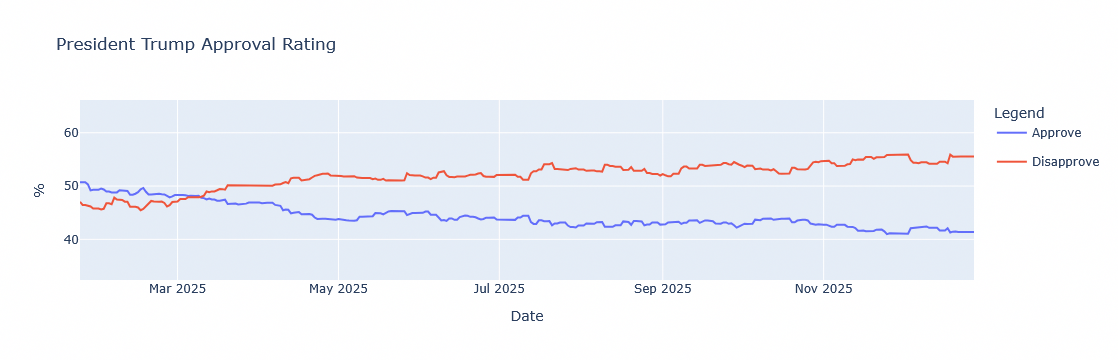

In [72]:
line = px.line(approval_avg, x='Date', y=['Approve', 'Disapprove'])
# scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['approve', 'disapprove'])
line.update_traces(hovertemplate=None)
line.update_layout(hovermode='x unified')
# scatter.update_traces(hovertemplate=None, hoverinfo='skip')
fig_approve_CI = go.Figure([
    go.Scatter(
        name='Approve CI Upper Bound',
        x = approval_avg['Date'],
        y = approval_avg['Approve'] + 1.96*approval_std['Approve'],
        mode='lines',
        marker=dict(color='#8be8f2'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    go.Scatter(
        name='Approve CI Lower Bound',
        x = approval_avg['Date'],
        y = approval_avg['Approve'] - 1.96*approval_std['Approve'],
        mode='lines',
        marker=dict(color='#8be8f2'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),  
])
fig_disapprove_CI = go.Figure([
    go.Scatter(
        name='Disapprove CI Upper Bound',
        x = approval_avg['Date'],
        y = approval_avg['Disapprove'] + 1.96*approval_std['Disapprove'],
        mode='lines',
        marker=dict(color='#a3cbec'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    go.Scatter(
        name='Disapprove CI Lower Bound',
        x = approval_avg['Date'],
        y = approval_avg['Disapprove'] - 1.96*approval_std['Disapprove'],
        mode='lines',
        marker=dict(color='#a3cbec'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),  
])

fig = go.Figure(data=line.data + fig_approve_CI.data + fig_disapprove_CI.data)
fig.update_layout(
    title='President Trump Approval Rating',
    xaxis_title='Date',
    yaxis_title='%',
    legend_title='Legend',
    hovermode='x unified'
)
fig.show()

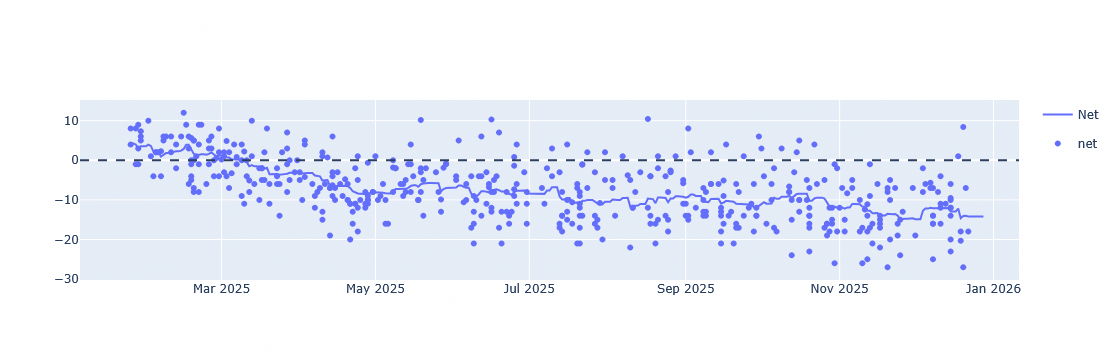

In [73]:
line = px.line(approval_avg, x='Date', y=['Net'])
scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['net'])
                     #trendline='lowess', trendline_options=dict(frac=0.2))
fig = go.Figure(data=line.data + scatter.data)
fig.add_hline(y=0, line_dash='dash')
fig.show()

In [74]:
# scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['net', 'net_adj'])
# fig = go.Figure(data=scatter.data)
# fig.add_hline(y=0, line_dash='dash')
# fig.show()

In [75]:
def net_col(df: pd.DataFrame, min_date: datetime.date):
#     df_copy = df.set_index(['Date'])
#     return df_copy['approve_mean'] - df_copy['disapprove_mean']
    date_range = pd.date_range(start=min_date, end=datetime.datetime.today(), freq='d', inclusive='both')
    data = df.copy()
    data['net_adj'] = data['approve_adj'] - data['disapprove_adj']
    net_averages = []
    net_stdevs = []
    issue_cols = {'Date': date_range, 'net':[], 'net_std':[]}
    for date in date_range:
    #         try:
            pipelined_df = avgs_pipeline(data, date)
    #         except TypeError:
    #             print('TypeError')
    #             print(date)
            net_avg = np.sum(pipelined_df['net_adj'] * pipelined_df['total_weights'])
            net_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['net_adj'] - net_avg)**2))

            net_averages.append(net_avg)
            net_stdevs.append(net_std)

    issue_cols['net'].extend(net_averages)
    issue_cols[f'net_std'].extend(net_stdevs)
        
    net_averages, net_stdevs = [], []
        
    return pd.DataFrame(issue_cols)

In [76]:
net_approval = net_col(approval, datetime.date(2025, 1, 23))
net_approval

,Date,net,net_std
0,2025-01-23,3.679375,7.981265
1,2025-01-24,4.259609,7.166751
2,2025-01-25,4.259609,7.166751
3,2025-01-26,3.992562,6.942108
4,2025-01-27,3.023654,6.211648
...,...,...,...
335,2025-12-24,-14.179362,7.658575
336,2025-12-25,-14.179362,7.658575
337,2025-12-26,-14.179362,7.658575
338,2025-12-27,-14.179362,7.658575


In [77]:
net_approval['net_upper_CI'] = net_approval['net'] + 1.96*net_approval['net_std']
net_approval['net_lower_CI'] = net_approval['net'] - 1.96*net_approval['net_std']
net_approval

,Date,net,net_std,net_upper_CI,net_lower_CI
0,2025-01-23,3.679375,7.981265,19.322655,-11.963904
1,2025-01-24,4.259609,7.166751,18.306442,-9.787224
2,2025-01-25,4.259609,7.166751,18.306442,-9.787224
3,2025-01-26,3.992562,6.942108,17.599093,-9.613970
4,2025-01-27,3.023654,6.211648,15.198484,-9.151176
...,...,...,...,...,...
335,2025-12-24,-14.179362,7.658575,0.831445,-29.190170
336,2025-12-25,-14.179362,7.658575,0.831445,-29.190170
337,2025-12-26,-14.179362,7.658575,0.831445,-29.190170
338,2025-12-27,-14.179362,7.658575,0.831445,-29.190170


In [78]:
net_approval.to_csv('net_approval.csv')

### Auxiliary Graph: Individual Pollsters

In [80]:
approval_polls.columns.values

array(['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size',
       'population', 'approve', 'disapprove', 'approve_adj',
       'disapprove_adj', 'net', 'url', 'pred_plus_minus', 'poll_id',
       'pollster_id'], dtype=object)

In [81]:
appr = full_approval.copy()
appr['net_adj'] = appr['approve'] - appr['disapprove']
appr = appr[~appr['pred_plus_minus'].isna()]
pollsters = appr['pollster'].value_counts().index.values
pollsters

array(['Rasmussen Reports', 'YouGov', 'Morning Consult', 'RMG Research',
       'Ipsos', 'Global Strategy Group/GBAO (Navigator Research)',
       'J.L. Partners', 'TIPP Insights', 'Echelon Insights',
       'Harris Insights & Analytics', 'Gallup', 'Emerson College',
       'Quinnipiac University', 'American Research Group',
       'John Zogby Strategies', 'Clarity Campaign Labs', 'AtlasIntel',
       'InsiderAdvantage', 'Beacon Research/Shaw & Co. Research',
       'Hart Research Associates/Public Opinion Strategies',
       'McLaughlin & Associates', 'SSRS', 'Marist College',
       'Marquette University Law School', 'Pew Research Center',
       'SurveyMonkey', 'Leger', 'GBAO', 'Cygnal', 'Civiqs',
       'Targoz Market Research', 'High Point University', 'co/efficient',
       'Wick', 'Fabrizio Lee & Associates/Impact Research',
       'The Winston Group', 'Public Religion Research Institute',
       'University of Massachusetts (Amherst)',
       'The New York Times/Siena College',

In [82]:
def approval_today(data: pd.DataFrame):
    # date_range = pd.date_range(start=datetime.date(2025, 1, 23), end=datetime.datetime.today(), freq='d', inclusive='both')
#     yes_averages = []
#     no_averages = []
#     yes_stdevs = []
#     no_stdevs = []
    pipelined_df = avgs_pipeline(data, datetime.datetime.today())
    yes_avg = np.sum(pipelined_df['approve'] * pipelined_df['total_weights'])
    no_avg = np.sum(pipelined_df['disapprove'] * pipelined_df['total_weights'])
    yes_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['approve'] - yes_avg)**2))
    no_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['disapprove'] - no_avg)**2))
    net_avg = np.sum(pipelined_df['net'] * pipelined_df['total_weights'])
    net_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['net'] - net_avg)**2))
    
    #return pd.DataFrame({'Date':date_range, 'Approve':yes_averages, 'Disapprove':no_averages}), pd.DataFrame({'Date':date_range, 'Approve':yes_stdevs, 'Disapprove':no_stdevs}), avgs_pipeline(data, datetime.datetime.today())
    return yes_avg, no_avg, yes_std, no_std, net_avg, net_std

In [83]:
def indiv_pollster_avg(pollster: str):
    df = appr[appr['pollster'] == pollster]
    yes_avg, no_avg, yes_std, no_std, net_avg, net_std = approval_today(df)
    return yes_avg, no_avg, yes_std, no_std, net_avg, net_std

In [84]:
def get_ppm(pollster: str):
    df = ratings[ratings['Pollster'] == pollster]
    ppm = df['Predictive Plus-Minus'].values[0]
    
    return ppm

In [85]:
appr.shape

(710, 27)

In [86]:
def get_num_polls(pollster: str):
    df = appr[appr['pollster'] == pollster]
    num_polls = df.shape[0]
    return num_polls

In [87]:
get_ppm('YouGov')

0.047635015

In [88]:
indiv_pollster_avg('YouGov')

(40.39598428593027,
 57.379487705877615,
 1.0873640031405498,
 1.8057408049941062,
 -16.983503419947347,
 2.2159845865775445)

In [89]:
indiv_pollster_avg('RMG Research')

(48.19805231418898,
 50.33333633998013,
 1.9464040500981878,
 1.544225209435078,
 -2.1352840257911616,
 3.472591842656574)

In [90]:
nets = []
net_stdevs = []
ppms = []
nums = []

for p in pollsters:
    _, _, _, _, net, net_std = indiv_pollster_avg(p)
    ppm = get_ppm(p)
    num_polls = get_num_polls(p)
    
    nets.append(net)
    net_stdevs.append(net_std)
    ppms.append(ppm)
    nums.append(num_polls)

In [91]:
# nets

In [92]:
indiv_avgs = pd.DataFrame({'Pollster': pollsters, 'Net Approval': nets, 'Net Stdev': net_stdevs, 'Predictive Plus-Minus': ppms, 'Number of Approval Polls Conducted': nums})
indiv_avgs = indiv_avgs.sort_values(['Net Approval'], ascending=True)
indiv_avgs

,Pollster,Net Approval,Net Stdev,Predictive Plus-Minus,Number of Approval Polls Conducted
13,American Research Group,-26.977319,0.309585,0.818141,11
21,SSRS,-25.998482,0.123199,0.966835,6
10,Gallup,-23.095370,0.804107,-0.096810,12
31,High Point University,-20.999135,0.088289,0.411680,3
16,AtlasIntel,-20.294598,0.286128,-0.957740,8
37,University of Massachusetts (Amherst),-19.998302,0.148581,0.536200,2
4,Ipsos,-18.111109,2.077866,0.442898,32
24,Pew Research Center,-18.064622,0.504813,0.132230,5
1,YouGov,-16.983503,2.215985,0.047635,84
22,Marist College,-16.096812,0.353549,-0.436610,6


In [93]:
indiv_avgs.to_csv('indiv_pollster_avgs.csv')

In [94]:
reg = lm.LinearRegression()
reg.fit(indiv_avgs[['Predictive Plus-Minus']], indiv_avgs['Net Approval'])
reg.coef_, reg.intercept_

(array([-2.69373672]), -8.53115244628409)

In [95]:
r = r_regression(indiv_avgs[['Predictive Plus-Minus']], indiv_avgs['Net Approval'])
r

array([-0.17706681])

In [96]:
net_approval['net'].diff()

0               NaN
1      5.802336e-01
2      0.000000e+00
3     -2.670470e-01
4     -9.689079e-01
           ...     
335   -3.552714e-15
336    3.552714e-15
337    0.000000e+00
338    0.000000e+00
339   -3.552714e-15
Name: net, Length: 340, dtype: float64

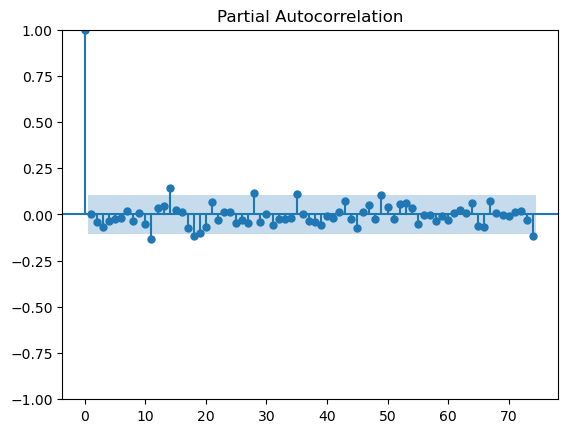

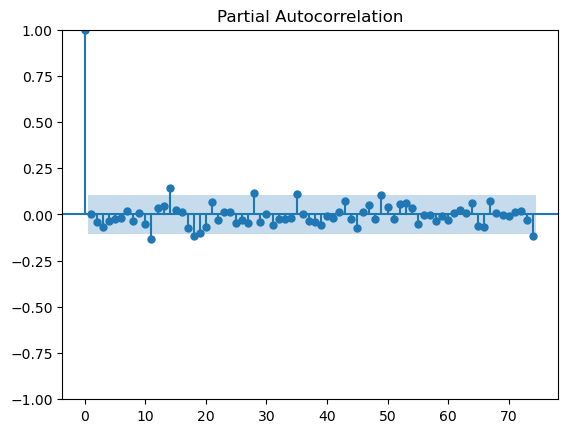

In [97]:
plot_pacf(net_approval['net'].diff()[1:], lags=np.arange(75))

In [98]:
armod_sm = AutoReg(net_approval['net'].diff()[1:].values, lags = 1, trend = 'c').fit()
# print(armod_sm.summary())

In [99]:
armod_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  339
Model:                     AutoReg(1)   Log Likelihood                -257.384
Method:               Conditional MLE   S.D. of innovations              0.518
Date:                Sun, 28 Dec 2025   AIC                            520.768
Time:                        13:48:41   BIC                            532.237
Sample:                             1   HQIC                           525.339
                                  339                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0545      0.028     -1.924      0.054      -0.110       0.001
y.L1           0.0006      0.054      0.012      0.990      -0.106       0.107
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         1541.9576           +0.0000j         1541.9576            0.0000
-----------------------------------------------------------------------------
"""

In [100]:
k, n_train = 15, 208
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([-0.0545189 , -0.05519661, -0.05360081, -0.0545189 , -0.0545189 ,
       -0.05458865, -0.05520967, -0.05391687, -0.0545189 , -0.05415423,
       -0.0545189 , -0.0545189 , -0.0545964 , -0.05465082, -0.05438201])